In [1]:
import ast
import matplotlib.pyplot as plt
import multiprocess as mp
import networkx as nx
import numpy as np
import os
import pandas as pd
import random
import sys
import torch

from collections import deque
from concorde.tsp import TSPSolver
from concorde.tests.data_utils import get_dataset_path
from graph_utils import plot_network
from python_tsp.exact import solve_tsp_dynamic_programming
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from pulp import *
from time import time
from torchsummary import summary

from agent import Agent
from env import MVCEnv, TSPEnv
from model import QNetwork
from solver import solve, solve2

%load_ext autoreload
%autoreload 2

/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
from torchsummary import summary

In [2]:
def run_episode(agent, env, eps=0, train_mode=True, print_actions=False):
    state = env.reset()
    agent.reset_episode(env.G)
    score = 0
    while True:
        action = agent.act(state, eps=eps)
        if print_actions:
            print(action)
        next_state, reward, done = env.step(action)
        score += reward
        if train_mode:
            agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break
    return score

In [3]:
def get_solver_solution(env):
    node_names = list(map(str, range(env.n)))
    node_vars = LpVariable.dicts("Node", node_names, 0, 1, LpInteger)

    prob = LpProblem("myProblem", LpMinimize)
    prob += lpSum(node_vars)

    for (u, v) in env.G.edges:
        prob += node_vars[str(u)] + node_vars[str(v)] >= 1

    prob.solve(PULP_CBC_CMD(msg=False))
    return value(prob.objective)

In [4]:
def get_solution(env, exact_solution_max_size=0, return_path=False):
    if env.G.number_of_nodes() <= exact_solution_max_size:
        raise NotImplemented("Exact solution not implemented yet")
    else:
        return get_solver_solution(env)

In [5]:
def run_validation(agent, env, n_episodes_validation, exact_solution_max_size=0, print_to_file=sys.stdout):
    agent.qnetwork_target.eval()
    agent.qnetwork_local.eval()
    val_scores = []
    for i in range(1, n_episodes_validation+1):
        run_episode(agent, env, train_mode=False)
        score = env.get_solution_score()
        solution = get_solution(env, exact_solution_max_size)
        approximation_ratio = score/solution
        val_scores.append(approximation_ratio)
    
    val_scores = np.array(val_scores)
    val_stats = pd.Series(val_scores).describe()
    print(
        f"[Validation] "
        f"Mean: {val_stats['mean']}, "
        f"Std dev: {val_stats['std']}, "
        f"Optimal: {100 * (abs(val_scores - 1.0) < 1e-6).sum() / n_episodes_validation :.2f}%",
        file=print_to_file
    )
    
    agent.qnetwork_target.train()
    agent.qnetwork_local.train()

    return val_stats

In [6]:
def train(agent, env, eps_start, eps_decay, eps_end, scheduler=None, n_episodes=10000,
          start_episode=1, validate_each=25, n_episodes_validation=10, print_train_metrics_each=100,
          print_thetas=True, validate_at_start=True, print_to_file=sys.stdout):
    scores = []
    val_scores = []
    eps = eps_start
    start_time = time()
    if validate_at_start:
        val_score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
        val_scores.append(val_score)
    for episode_idx in range(start_episode, n_episodes + 1):
        try:
            # run episode for given episode_idx
            score = run_episode(agent, env, eps, train_mode=True)
            eps = max(eps * eps_decay if eps_decay >= 0 else eps + eps_decay, eps_end)
            scores.append(score)
            
            # update the LR scheduler
            if isinstance(scheduler, LambdaLR):
                scheduler.step()

            if episode_idx % print_train_metrics_each == 0:
                print(
                    f"[{episode_idx}/{n_episodes}] "
                    f"loss: {agent.losses[-1]:.3e}, "
                    f"q_target: {agent.q_targets[-1]:.3e}, "
                    f"q_expected: {agent.q_expecteds[-1]:.3e}, "
                    f"eps: {eps:.4f}, "
                    f"time: {time() - start_time:.2f}s",
                    file=print_to_file,
                    flush=True
                )
                if print_thetas:
                    print(f"    θ1: {agent.theta1s[-1]:.3e}, "
                        f"θ2: {agent.theta2s[-1]:.3e}, "
                        f"θ3: {agent.theta3s[-1]:.3e}, "
                        # f"θ4: {agent.theta4s[-1]:.3e}, "
                        f"θ5: {agent.theta5s[-1]:.3e}, "
                        f"θ6: {agent.theta6s[-1]:.3e}, "
                        f"θ7: {agent.theta7s[-1]:.3e}",
                        file=print_to_file
                    )
            
            # check if we should run validation
            if episode_idx % validate_each == 0:
                score = run_validation(agent, env, n_episodes_validation, print_to_file=print_to_file)['mean']
                if isinstance(scheduler, ReduceLROnPlateau):
                    scheduler.step(score)
                val_scores.append(score)
        except KeyboardInterrupt:
            print(f"Training interrupted in episode #{episode_idx}")
            break
    print(f"Total time: {time() - start_time:.2f}s", file=print_to_file)
    return scores, val_scores

In [7]:
def eps_analysis(eps_start, eps_decay, eps_end, n, decay, check_episodes=35000):
    if decay == 'exponential':
        return np.argmin([eps_start * (eps_decay ** (n*i)) > eps_end for i in range(check_episodes)])
    elif decay == 'linear':
        return 0
    raise ValueError('decay should be either "exponential" or "linear"')

In [8]:
def lr_lambda(lr_config):
    '''
    lr_config: list of tuples (start_episode, lr_value)
    '''
    def f(episode):
        for i in range(len(lr_config) - 1, -1, -1):
            start_episode, lr_value = lr_config[i]
            if episode >= start_episode:
                return lr_value
        raise ValueError("lr_config should have its first element starting at episode 0")
    return f

In [9]:
def plot_graphs(agent_losses, val_scores, max_loss=1.0, filename=None, **kwargs):
    agent_losses = np.atleast_2d(agent_losses)
    val_scores = np.atleast_2d(val_scores)    

    title_keys = ['n', 'lr_config', 'batch_size']
    title_config = ', '.join([f'{k} = {kwargs[k]}' for k in title_keys])
    # title_config = f'n = {n}, lr = {lr_config}'
    fig, ax = plt.subplots(2, 1, figsize=(10,8))

    losses_df = pd.DataFrame(agent_losses).T
    losses_df.plot(color='b', alpha=0.05, legend=False, xlabel='Minibatch', ylabel='Loss Value', ax=ax[0]);
    losses_df.mean(axis=1).plot(color='r', title=f'Loss Function\n{title_config}', ax=ax[0]);

    ax[0].set_title(f'Loss function\n{title_config}')
    ax[0].set_ylim((0, max_loss))

    val_df = pd.DataFrame(val_scores).T
    val_x_start = 0 if kwargs.get('validate_at_start', False) else 1
    val_x = pd.DataFrame({'x': np.arange(val_x_start, len(val_scores[0]) + 1) * kwargs.get('validate_each', 1)})

    pd.concat([val_df, val_x], axis=1).plot(x='x', color='b', alpha=0.05, legend=False, xlabel='Validation Episode', ylabel='Approximation Ratio', ax=ax[1]);
    pd.concat([val_df.mean(axis=1), val_x], axis=1).plot(x='x', color='r', legend=False, title=f'Validation scores\n{title_config}', ax=ax[1]);
    ax[1].set_title('Validation scores')

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

In [10]:
def replay_graphs(outputs_prefix, max_loss=1.0, filename=None):
    with open(f'{outputs_prefix}_loss.log') as f:
        agent_losses_str = f.read()
    agent_losses = ast.literal_eval(agent_losses_str)
    with open(f'{outputs_prefix}_val.log') as f:
        val_scores_str = f.read()
    with open(f'{outputs_prefix}.log') as f:
        config_str = f.readlines()[0].strip()
    config = ast.literal_eval(config_str)
    val_scores = ast.literal_eval(val_scores_str)
    plot_graphs(agent_losses, val_scores, max_loss=max_loss, filename=filename,
                n=config['n'], lr_config=config['lr_config'], batch_size=config['batch_size'],
                validate_each=config.get('validate_each', 1), validate_at_start=config.get('validate_at_start', False))

In [11]:
eps_start = 0.999
eps_end = 0.01
n = 15
nstep = 5
eps_end_at_episode = 5
eps_decay = (eps_end - eps_start) / eps_end_at_episode
eps_decay

eps = eps_start
print(eps)
for episode in range(eps_end_at_episode):
    eps += eps_decay
    print(eps)

0.999
0.8012
0.6034
0.40560000000000007
0.20780000000000007
0.010000000000000064


In [12]:
def run_train(experiment_idx, n_runs, p):
    all_agent_losses = []
    all_val_scores = []
    
    n = p['n']
    n_episodes = p['n_episodes']
    eps_start = p['eps_start']
    eps_end = p['eps_end']
    eps_end_at_episode = p['eps_end_at_episode']
    decay_type = p.get('decay_type', 'linear')
    batch_size = p['batch_size']
    validate_at_start = p.get('validate_at_start', False)
    
    # transform relative to absolute episode number
    lr_config = p['lr_config']
    lr_config = [(int(ep * n_episodes), lr) if 0 < ep <= 1 else (ep, lr) for (ep, lr) in lr_config]
    
    filename = 'outputs-mvc/run_{}.{}'
    f_log = open(filename.format(experiment_idx, 'log'), 'w')
    f_loss = open(filename.format(f'{experiment_idx}_loss', 'log'), 'w')
    f_val = open(filename.format(f'{experiment_idx}_val', 'log'), 'w')
    filename_plot = filename.format(experiment_idx, 'png')
    
    print(p)
    print(p, file=f_log)
    
    agents = []
    for run_idx in range(n_runs):
        agent = Agent(
            nstep=p.get('nstep', 1),
            normalize=p.get('normalize', True),
            batch_size=batch_size,
            lr=1, # LR is set via LR scheduler  
            n_node_features=1,
            n_edge_features=0,
            T=5
        )
        
        env = MVCEnv(n_min=n, n_max=n, graph_type=p['graph_type'])

        scheduler = LambdaLR(agent.optimizer, lr_lambda=lr_lambda(lr_config), verbose=False)

        if 0 < eps_end_at_episode <= 1:
            eps_end_at_episode = round(eps_end_at_episode * n_episodes)
        
        if decay_type == 'exponential':
            # exponential decay derived from formula eps_end = eps_start * (eps_decay ** episode)
            eps_decay = (eps_end / eps_start) ** (1 / eps_end_at_episode)
        elif decay_type == 'linear':
            # linear decay derived from formula eps_end = eps_start + (eps_decay * episode)
            eps_decay = (eps_end - eps_start) / eps_end_at_episode

        print(f'Starting run #{run_idx+1}/{n_runs}...')
        print(f'Starting run #{run_idx+1}/{n_runs}...', file=f_log)
        scores, val_scores = train(
            agent, env, eps_start, eps_decay, eps_end,
            scheduler=scheduler, n_episodes=n_episodes,
            validate_each=p['validate_each'], print_train_metrics_each=p['print_train_metrics_each'],
            print_thetas=False, print_to_file=f_log, validate_at_start=validate_at_start)

        agents.append(agent)
        all_agent_losses.append(agent.losses)
        all_val_scores.append(val_scores)

    # print(f"{filename.format(experiment_idx, 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_loss', 'log')=}")
    # print(f"{filename.format(f'{experiment_idx}_val', 'log')=}")
    # print(f"{all_agent_losses=}")
    # print(f"{all_val_scores=}")

    # TODO: remove [0]
    print(all_agent_losses[0], file=f_loss)
    print(all_val_scores, file=f_val)
    
    f_log.close()
    f_loss.close()
    f_val.close()
#     with open(filename.format(f'{experiment_idx}_loss', 'log'), 'w') as f:
#         f.write(str(all_agent_losses))

#     with open(filename.format(f'{experiment_idx}_val', 'log'), 'w') as f:
#         f.write(str(all_val_scores))

    # print(filename.format(experiment_idx, 'png'))
    # TODO: remove [0] from all_agent_losses[0]
    plot_graphs(all_agent_losses[0], all_val_scores, max_loss=1, filename=filename_plot,
                n=n, lr_config=lr_config, batch_size=batch_size,
                validate_each=p['validate_each'], validate_at_start=validate_at_start)
    
    return agents

{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 2500, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/2...
CPU times: user 7min, sys: 2min 20s, total: 9min 20s
Wall time: 8min 28s


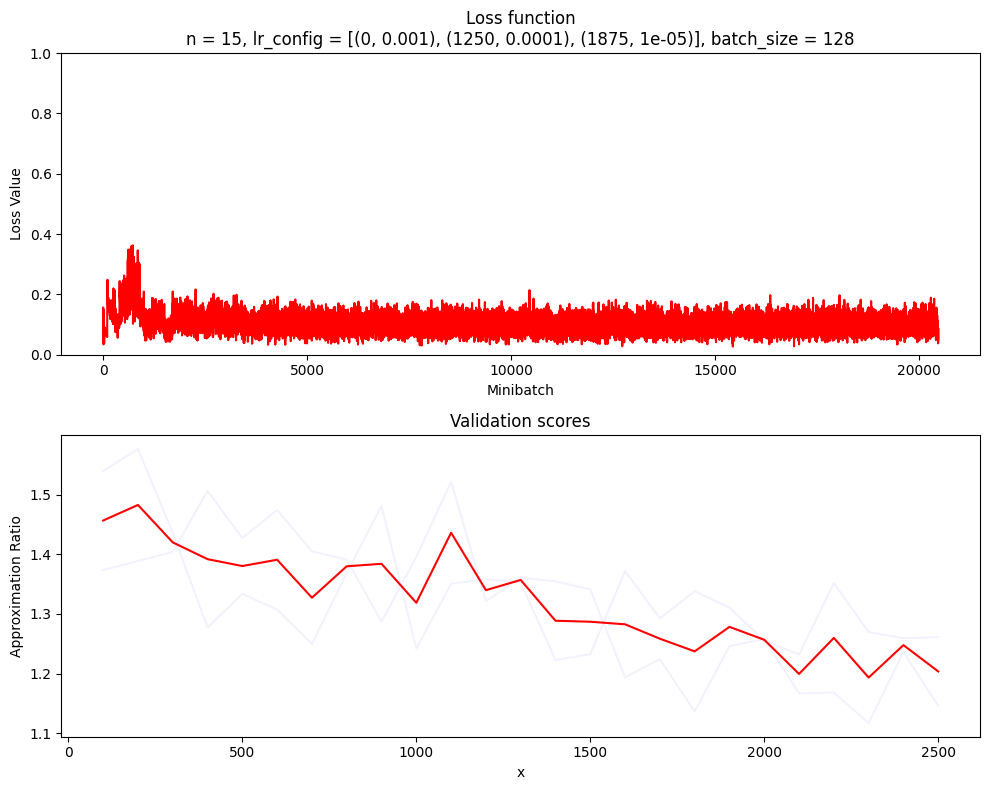

In [13]:
%%time
params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 2500,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(9, 2, params)

In [26]:
mvc_env = MVCEnv(n_min=15, n_max=15, graph_type=MVCEnv.BARABASI_ALBERT)
state = mvc_env.reset()

In [29]:
summary(agents[0].qnetwork_local, state.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 15, 64]              64
            Linear-2               [-1, 15, 64]           4,096
    EmbeddingLayer-3               [-1, 15, 64]               0
            Linear-4               [-1, 15, 64]              64
            Linear-5               [-1, 15, 64]           4,096
    EmbeddingLayer-6               [-1, 15, 64]               0
            Linear-7               [-1, 15, 64]              64
            Linear-8               [-1, 15, 64]           4,096
    EmbeddingLayer-9               [-1, 15, 64]               0
           Linear-10               [-1, 15, 64]              64
           Linear-11               [-1, 15, 64]           4,096
   EmbeddingLayer-12               [-1, 15, 64]               0
           Linear-13               [-1, 15, 64]              64
           Linear-14               [-1,

In [18]:
agents[0].qnetwork_local

MPNN(
  (batch_norm_embedding): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (embedding_layer): EmbeddingLayer(
    (theta1): Linear(in_features=1, out_features=64, bias=False)
    (theta2): Linear(in_features=64, out_features=64, bias=False)
    (theta3): Linear(in_features=64, out_features=64, bias=False)
    (theta4): Linear(in_features=0, out_features=64, bias=False)
  )
  (batch_norm_q): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (q_layer): QNetwork(
    (theta5): Linear(in_features=128, out_features=1, bias=False)
    (theta6): Linear(in_features=64, out_features=64, bias=False)
    (theta7): Linear(in_features=64, out_features=64, bias=False)
  )
)

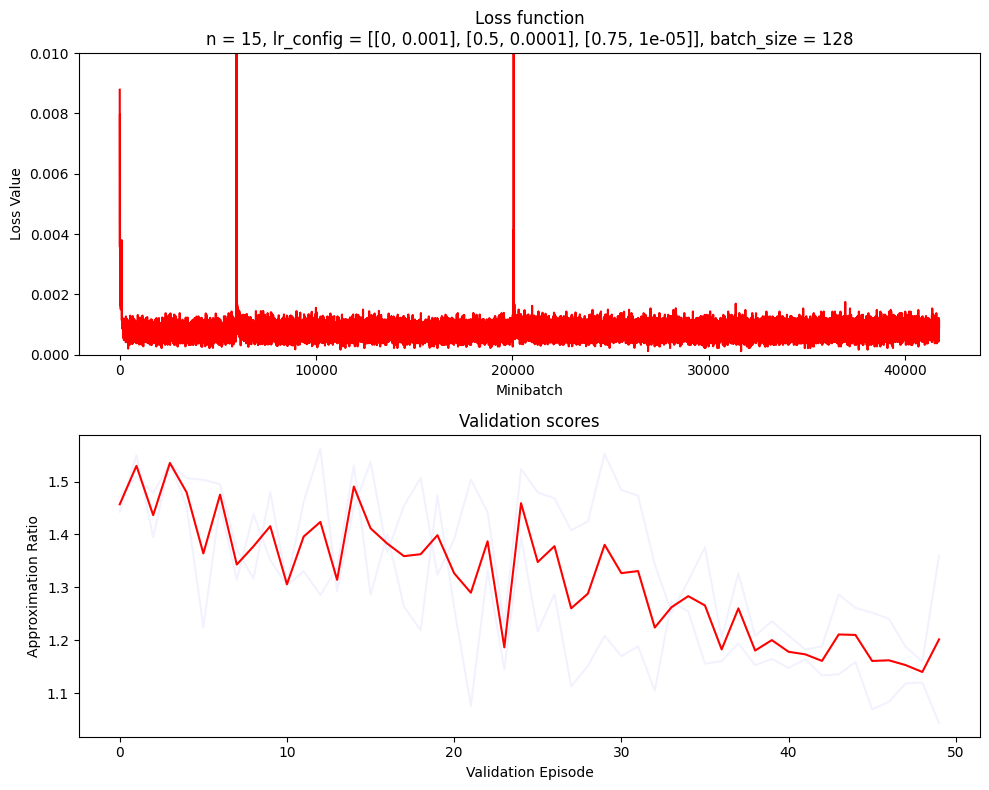

In [291]:
replay_graphs('outputs-mvc/run_3', max_loss=1e-2, filename=None)

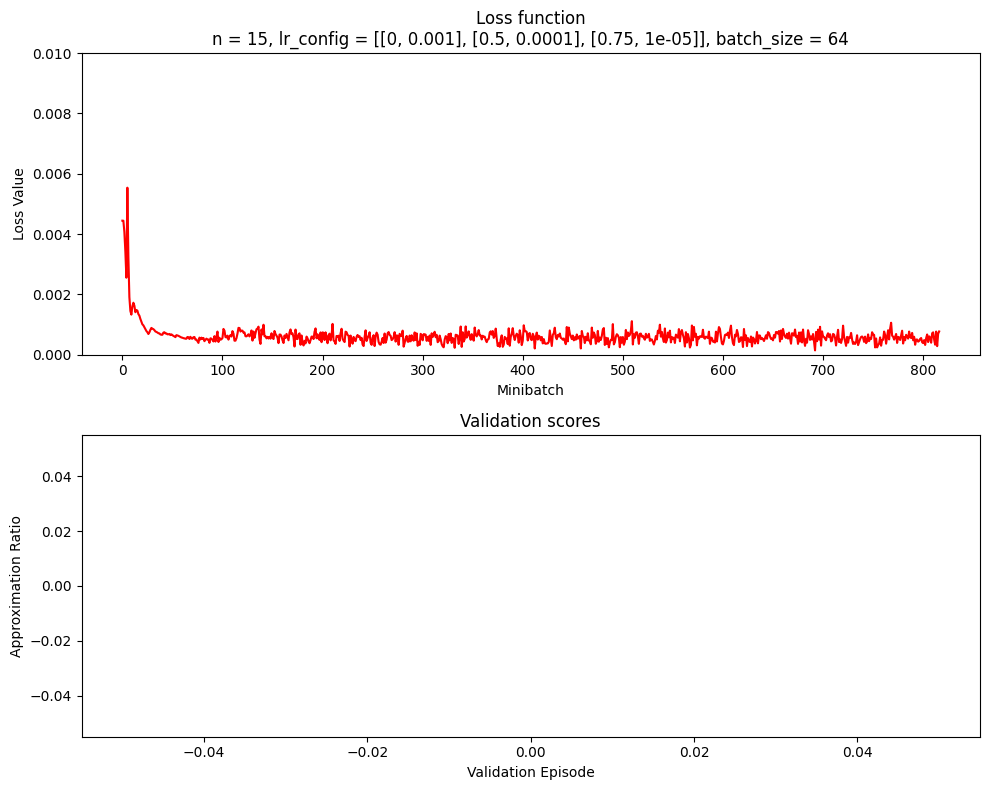

In [260]:
replay_graphs('outputs-mvc/run_0', max_loss=1e-2, filename=None)

{'n': 15, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'n_episodes': 2000, 'eps_start': 1.0, 'eps_end': 0.005, 'eps_end_at_episode': 0.8, 'validate_each': 1000000, 'print_train_metrics_each': 10, 'batch_size': 64}
Starting run #1/2...
Starting run #2/2...
CPU times: user 3min 37s, sys: 49.9 s, total: 4min 27s
Wall time: 4min 17s


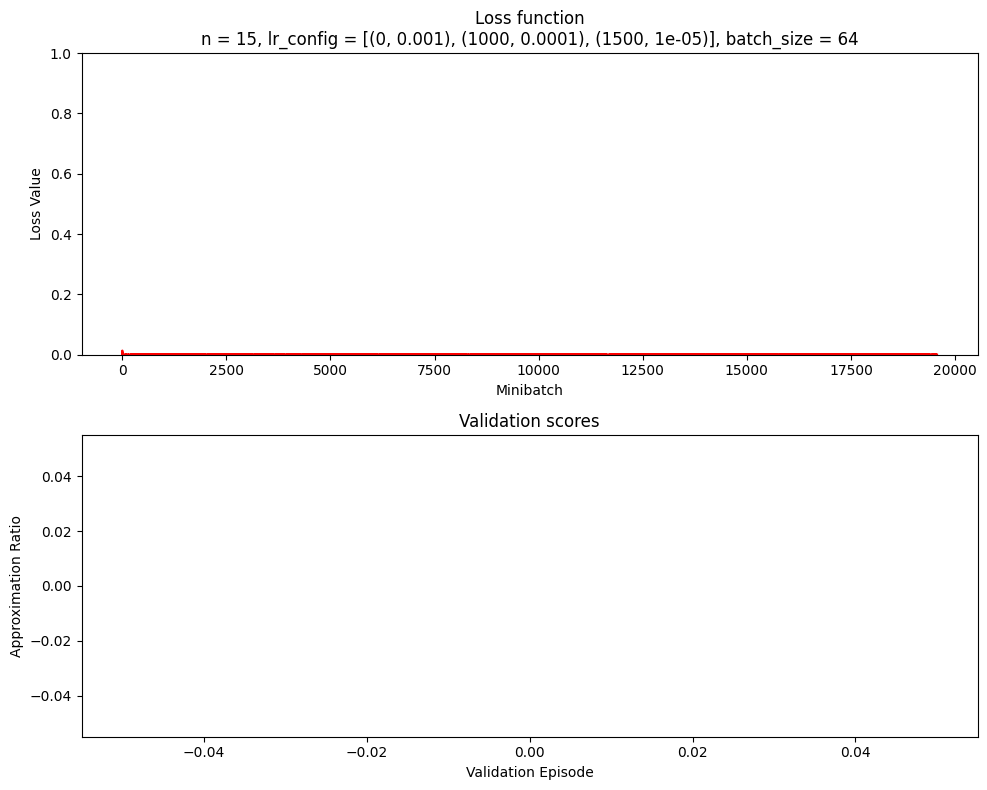

In [74]:
%%time
params = {
    'n': 15,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    # 'n': [3, 4, 5],
    'n_episodes': 2000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.005,
    'eps_end_at_episode': 0.8,
    'validate_each': 1000000,
    'print_train_metrics_each': 10,
    'batch_size': 64
}
agents = run_train(1, 2, params)

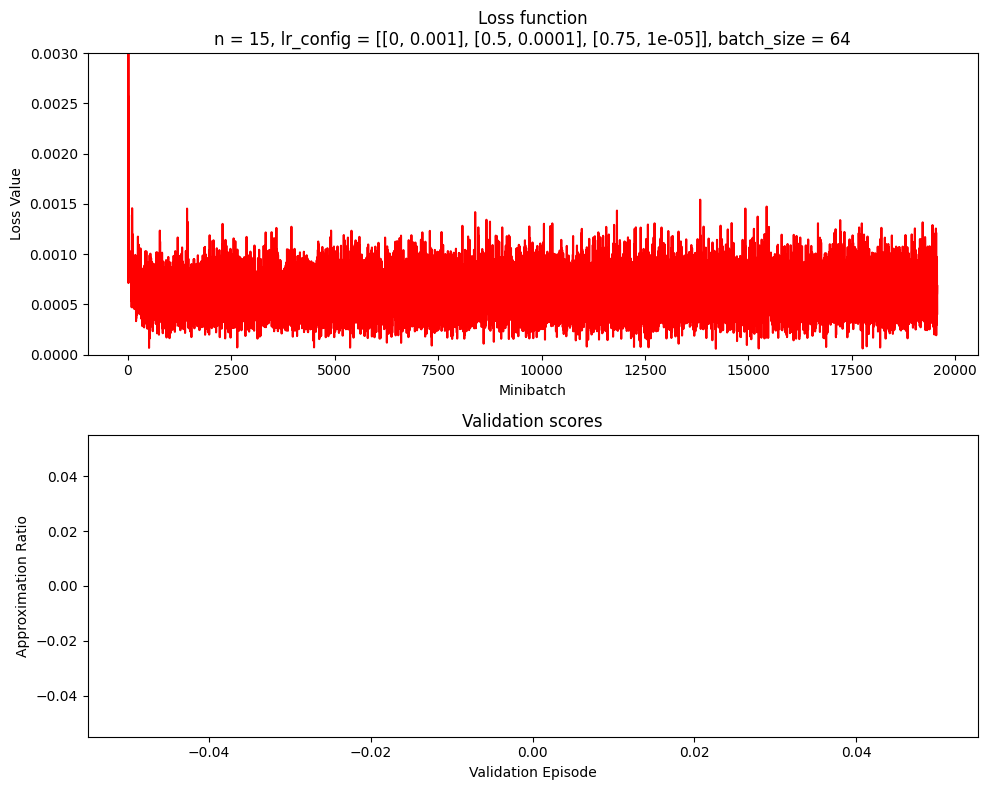

In [87]:
replay_graphs('outputs-mvc/run_1', max_loss=3e-3, filename=None)

## Linear epsilon decay

{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.05, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/2...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/2...
CPU times: user 14min 36s, sys: 4min 33s, total: 19min 9s
Wall time: 1h 28min 27s


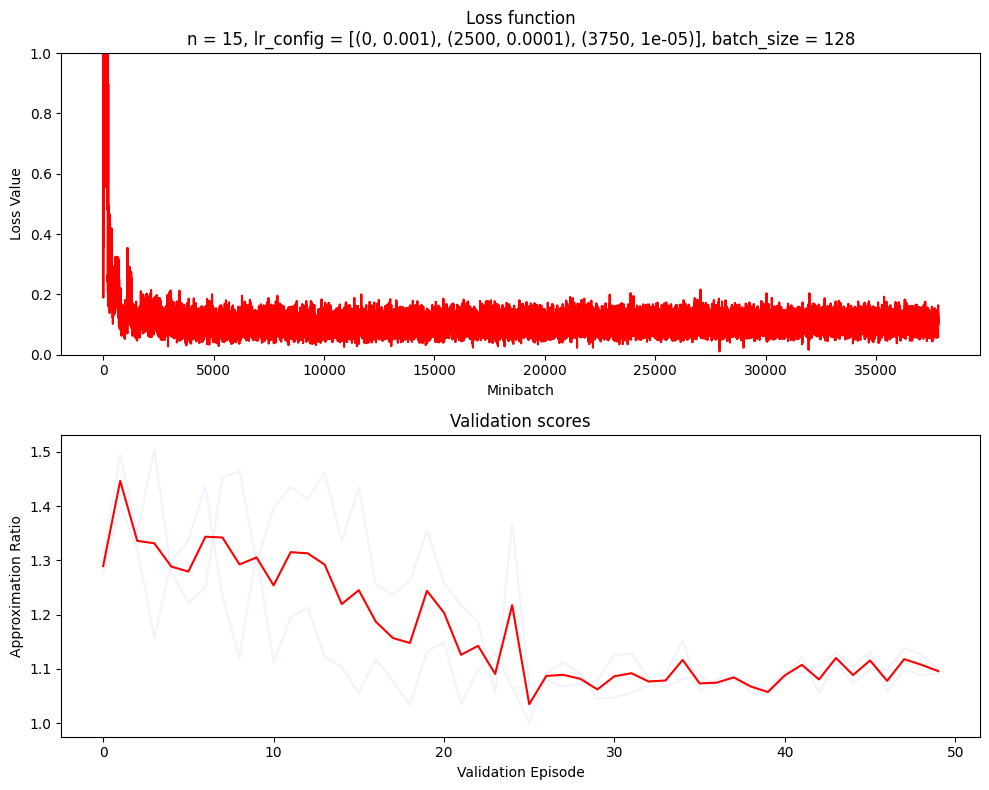

In [67]:
%%time

params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.05,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(4, 2, params)

{'n': 15, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 1, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 250, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #3/3...
CPU times: user 20min 47s, sys: 4min 52s, total: 25min 39s
Wall time: 23min 23s


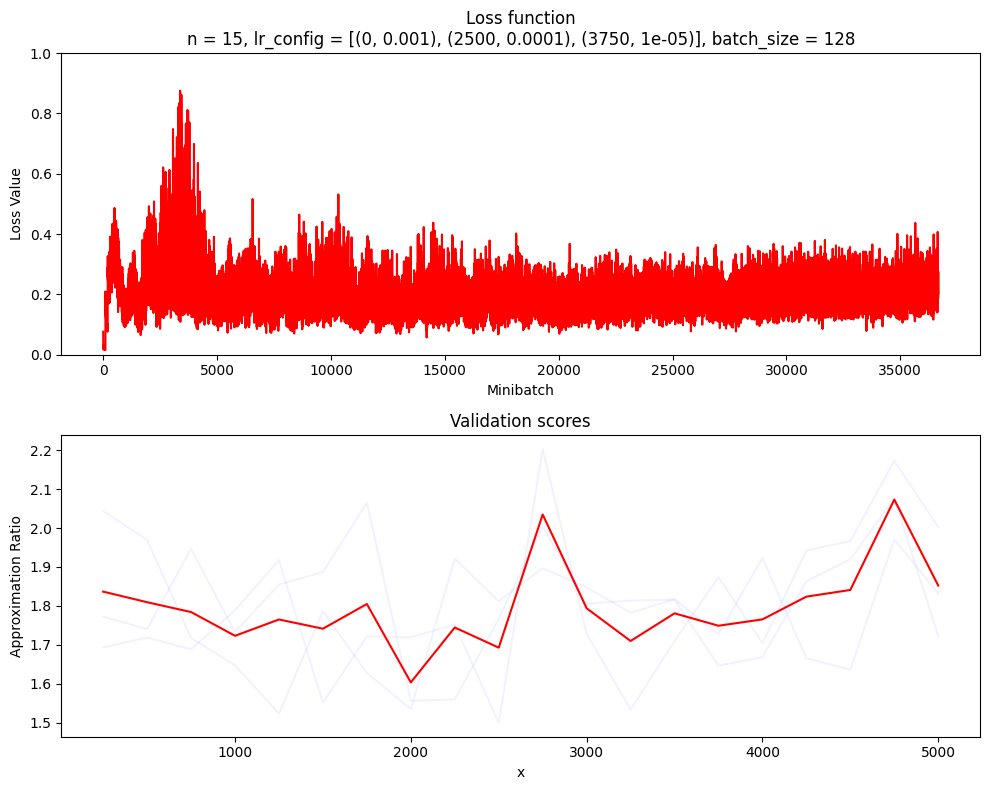

In [128]:
%%time

params = {
    'n': 15,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.ERDOS_RENYI,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 250,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(6, 3, params)

{'n': 15, 'nstep': 1, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #3/3...
CPU times: user 31min 31s, sys: 8min 44s, total: 40min 16s
Wall time: 36min 49s


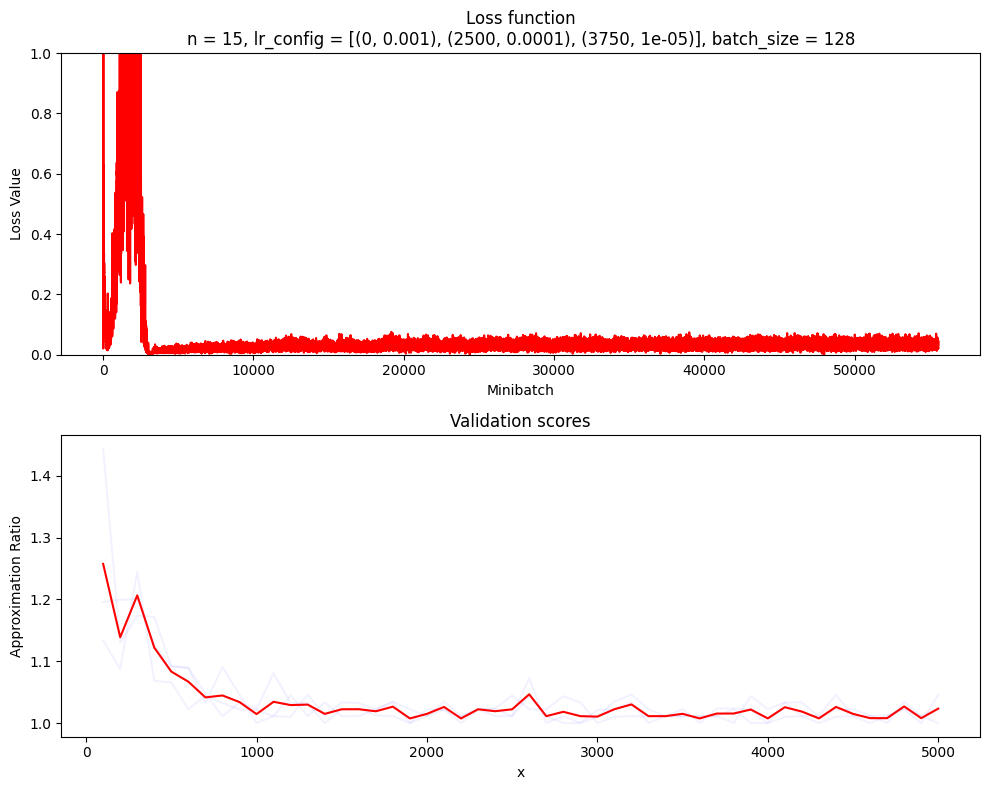

In [129]:
%%time

params = {
    'n': 15,
    'nstep': 1,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(6, 3, params)

{'n': 25, 'nstep': 5, 'lr_config': [[0, 0.001], [0.5, 0.0001], [0.75, 1e-05]], 'graph_type': 2, 'n_episodes': 5000, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_end_at_episode': 1.0, 'decay_type': 'linear', 'validate_each': 100, 'print_train_metrics_each': 10, 'batch_size': 128}
Starting run #1/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #2/3...


/Users/tiagomontalvao/.virtualenvs/msc/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Starting run #3/3...
CPU times: user 42min 55s, sys: 23min 16s, total: 1h 6min 12s
Wall time: 50min 35s


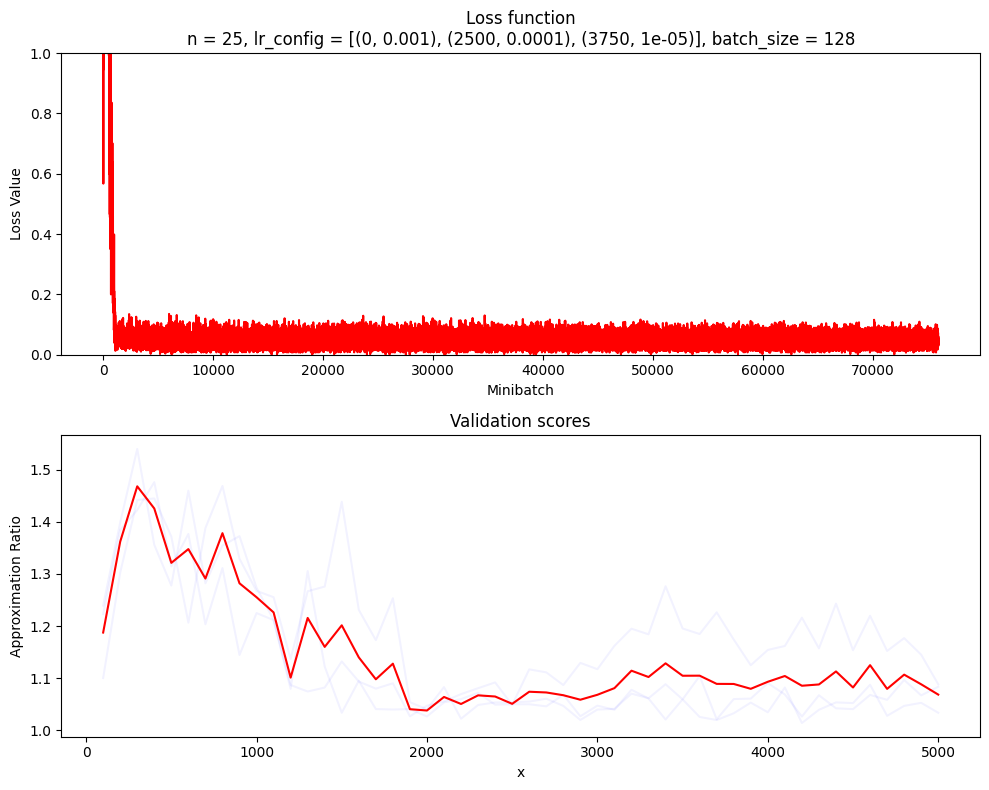

In [130]:
%%time

params = {
    'n': 25,
    'nstep': 5,
    'lr_config': [[0, 1e-3], [0.5, 1e-4], [0.75, 1e-5]],
    'graph_type': MVCEnv.BARABASI_ALBERT,
    # 'n': [3, 4, 5],
    'n_episodes': 5000,
    # 'n_episodes': [100],
    'eps_start': 1.00,
    'eps_end': 0.01,
    'eps_end_at_episode': 1.0,
    'decay_type': 'linear',
    'validate_each': 100,
    'print_train_metrics_each': 10,
    'batch_size': 128
}
agents = run_train(7, 3, params)

In [26]:
n = 15
env = MVCEnv(n, n, graph_type=MVCEnv.BARABASI_ALBERT)
agent = Agent(
    nstep=1,
    normalize=True,
    batch_size=16,
    lr=1e-4, # LR is set via LR scheduler 
    n_node_features=1,
    n_edge_features=0,
    T=5
)

eps_start = 1.0
eps_end = 0.01
eps_end_at_episode = 0.9
eps_decay = (eps_end / eps_start) ** (1 / (n * eps_end_at_episode))
scores, val_scores = train(agent, env, eps_start, eps_decay,
                           eps_end, n_episodes=1000, validate_each=100000, validate_at_start=False)

[100/1000] loss: 1.209e-04, q_target: -7.548e-02, q_expected: -9.178e-02, eps: 0.0100, time: 3.33s
    θ1: -1.526e-01, θ2: -6.781e-02, θ3: 9.410e-03, θ5: 8.239e-02, θ6: 3.055e-02, θ7: -4.003e-02
[200/1000] loss: 3.744e-04, q_target: -7.401e-02, q_expected: -7.786e-02, eps: 0.0100, time: 6.48s
    θ1: -1.599e-01, θ2: -6.797e-02, θ3: 9.410e-03, θ5: 8.238e-02, θ6: 3.055e-02, θ7: -4.084e-02
[300/1000] loss: 1.068e-03, q_target: -7.455e-02, q_expected: -8.647e-02, eps: 0.0100, time: 9.93s
    θ1: -1.627e-01, θ2: -6.814e-02, θ3: 9.410e-03, θ5: 8.237e-02, θ6: 3.055e-02, θ7: -4.171e-02
[400/1000] loss: 3.568e-04, q_target: -7.481e-02, q_expected: -8.155e-02, eps: 0.0100, time: 13.19s
    θ1: -1.652e-01, θ2: -6.829e-02, θ3: 9.410e-03, θ5: 8.235e-02, θ6: 3.055e-02, θ7: -4.284e-02
[500/1000] loss: 2.072e-05, q_target: -7.501e-02, q_expected: -8.246e-02, eps: 0.0100, time: 16.56s
    θ1: -1.661e-01, θ2: -6.836e-02, θ3: 9.410e-03, θ5: 8.232e-02, θ6: 3.056e-02, θ7: -4.375e-02
[600/1000] loss: 3.639e

In [27]:
len(scores)

1000

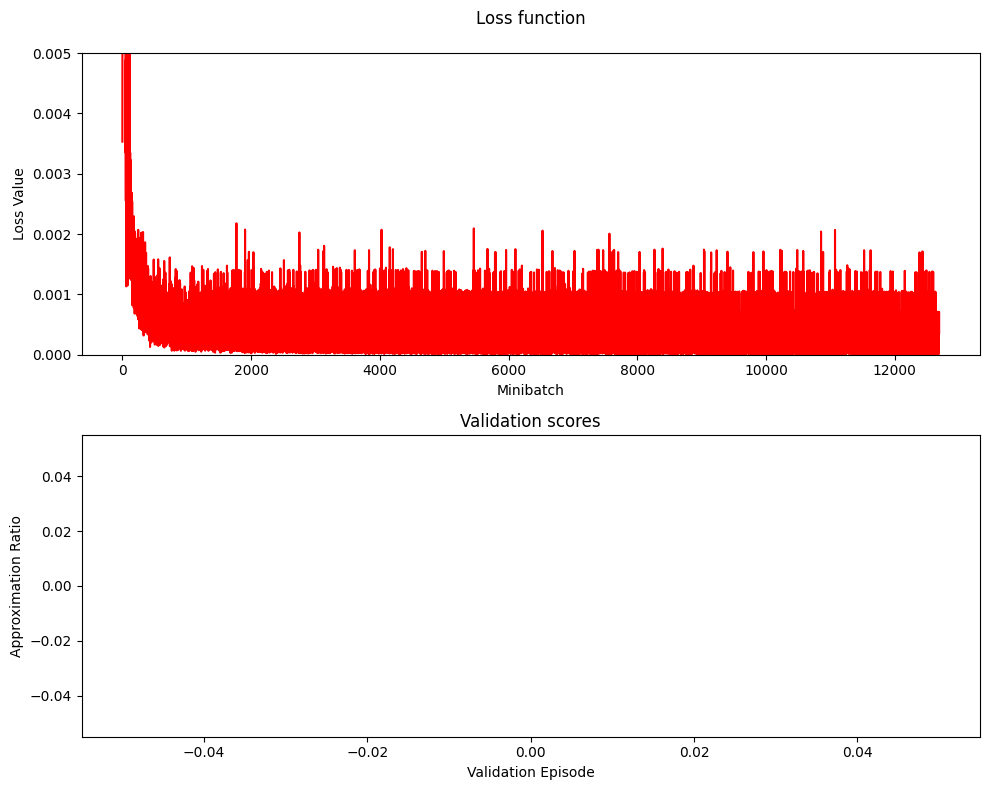

In [30]:
plot_graphs(agent.losses, [], max_loss=0.005)